各分布与N(2,0.1)的Square MMD值：
N(-1, 2): 1.0922
N(-1, 1): 1.3246
N(-1, 0.1): 1.7836


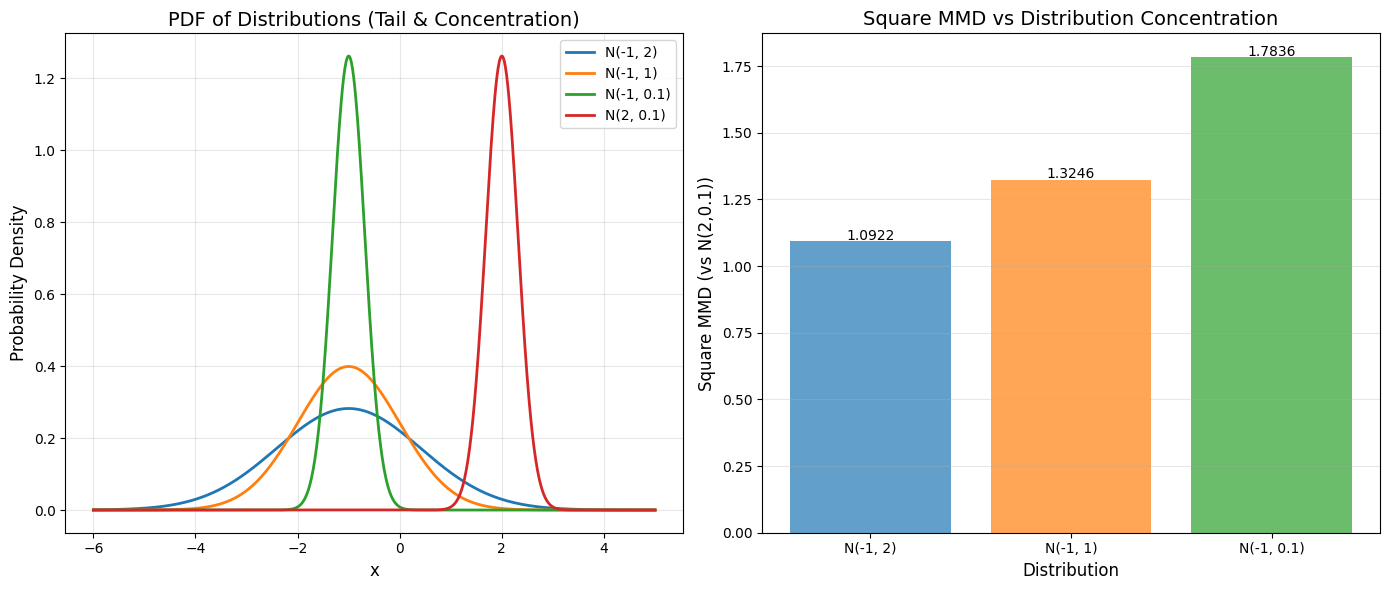

KeyError: 'N(2,0.1)'

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.spatial.distance import cdist

# ====================== 1. 实现Square MMD（高斯核）计算 ======================
def gaussian_kernel(x, y, sigma=1.0):
    """高斯核函数：k(x,y) = exp(-||x-y||²/(2σ²))"""
    pairwise_dist = cdist(x.reshape(-1,1), y.reshape(-1,1), 'sqeuclidean')
    return np.exp(-pairwise_dist / (2 * sigma**2))

def square_mmd(x, y, sigma=1.0):
    """计算Square MMD：MMD²(P,Q) = E[k(x,x')] + E[k(y,y')] - 2E[k(x,y)]"""
    # 计算三个项
    k_xx = np.mean(gaussian_kernel(x, x, sigma))
    k_yy = np.mean(gaussian_kernel(y, y, sigma))
    k_xy = np.mean(gaussian_kernel(x, y, sigma))
    return k_xx + k_yy - 2 * k_xy

# ====================== 2. 生成分布样本 ======================
# 定义四个分布的参数：均值(μ)、方差(σ²)
dist_params = {
    "N(-1, 2)": {"mu": -1, "var": 2, "color": "#1f77b4"},  # 方差大，tail重
    "N(-1, 1)": {"mu": -1, "var": 1, "color": "#ff7f0e"},  # 中等方差
    "N(-1, 0.1)": {"mu": -1, "var": 0.1, "color": "#2ca02c"},  # 方差小，tail轻
    "N(2, 0.1)": {"mu": 2, "var": 0.1, "color": "#d62728"}  # 目标分布（集中）
}

# 生成每个分布的样本（样本量足够大，保证MMD计算稳定）
np.random.seed(42)  # 固定随机种子，结果可复现
sample_size = 10000
samples = {}
for name, params in dist_params.items():
    sigma = np.sqrt(params["var"])  # 标准差=√方差
    samples[name] = np.random.normal(loc=params["mu"], scale=sigma, size=sample_size)

# ====================== 3. 计算前三个分布与N(2,0.1)的MMD值 ======================
target_dist = "N(2, 0.1)"
mmd_results = {}
for name in ["N(-1, 2)", "N(-1, 1)", "N(-1, 0.1)"]:
    mmd = square_mmd(samples[name], samples[target_dist], sigma=1.0)
    mmd_results[name] = mmd

# 打印MMD结果
print("各分布与N(2,0.1)的Square MMD值：")
for name, mmd in mmd_results.items():
    print(f"{name}: {mmd:.4f}")

# ====================== 4. 可视化 ======================
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# 子图1：绘制四个分布的PDF（直观看尾部和集中程度）
x_range = np.linspace(-6, 5, 1000)
ax1 = axes[0]
for name, params in dist_params.items():
    sigma = np.sqrt(params["var"])
    pdf = norm.pdf(x_range, loc=params["mu"], scale=sigma)
    ax1.plot(x_range, pdf, label=name, color=params["color"], linewidth=2)
ax1.set_xlabel("x", fontsize=12)
ax1.set_ylabel("Probability Density", fontsize=12)
ax1.set_title("PDF of Distributions (Tail & Concentration)", fontsize=14)
ax1.legend(fontsize=10)
ax1.grid(alpha=0.3)

# 子图2：MMD值柱状图
ax2 = axes[1]
dist_names = list(mmd_results.keys())
mmd_values = list(mmd_results.values())
colors = [dist_params[name]["color"] for name in dist_names]

bars = ax2.bar(dist_names, mmd_values, color=colors, alpha=0.7)
# 在柱子上标注MMD值
for bar, val in zip(bars, mmd_values):
    ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.005,
             f"{val:.4f}", ha="center", fontsize=10)

ax2.set_xlabel("Distribution", fontsize=12)
ax2.set_ylabel("Square MMD (vs N(2,0.1))", fontsize=12)
ax2.set_title("Square MMD vs Distribution Concentration", fontsize=14)
ax2.grid(alpha=0.3, axis="y")

plt.tight_layout()
plt.show()

# ====================== 5. 额外：可视化方差与MMD的关系（更直观） ======================
# 生成一系列方差，计算对应的MMD
variances = np.linspace(0.01, 3, 50)  # 方差从0.01到3
mmd_trend = []
mu_fixed = -1  # 固定均值为-1，仅改变方差
target_samples = samples["N(2,0.1)"]

for var in variances:
    sigma = np.sqrt(var)
    sample = np.random.normal(loc=mu_fixed, scale=sigma, size=sample_size)
    mmd = square_mmd(sample, target_samples, sigma=1.0)
    mmd_trend.append(mmd)

# 绘制方差-MMD趋势图
plt.figure(figsize=(10, 6))
plt.plot(variances, mmd_trend, color="#1f77b4", linewidth=2)
plt.scatter([2, 1, 0.1], [mmd_results["N(-1, 2)"], mmd_results["N(-1, 1)"], mmd_results["N(-1, 0.1)"]],
            color=["#1f77b4", "#ff7f0e", "#2ca02c"], s=100, zorder=5, label="Selected Points")

plt.xlabel("Variance of N(-1, var)", fontsize=12)
plt.ylabel("Square MMD (vs N(2,0.1))", fontsize=12)
plt.title("MMD Increases with Variance (Lighter Tail → Smaller MMD)", fontsize=14)
plt.legend(fontsize=10)
plt.grid(alpha=0.3)
plt.show()

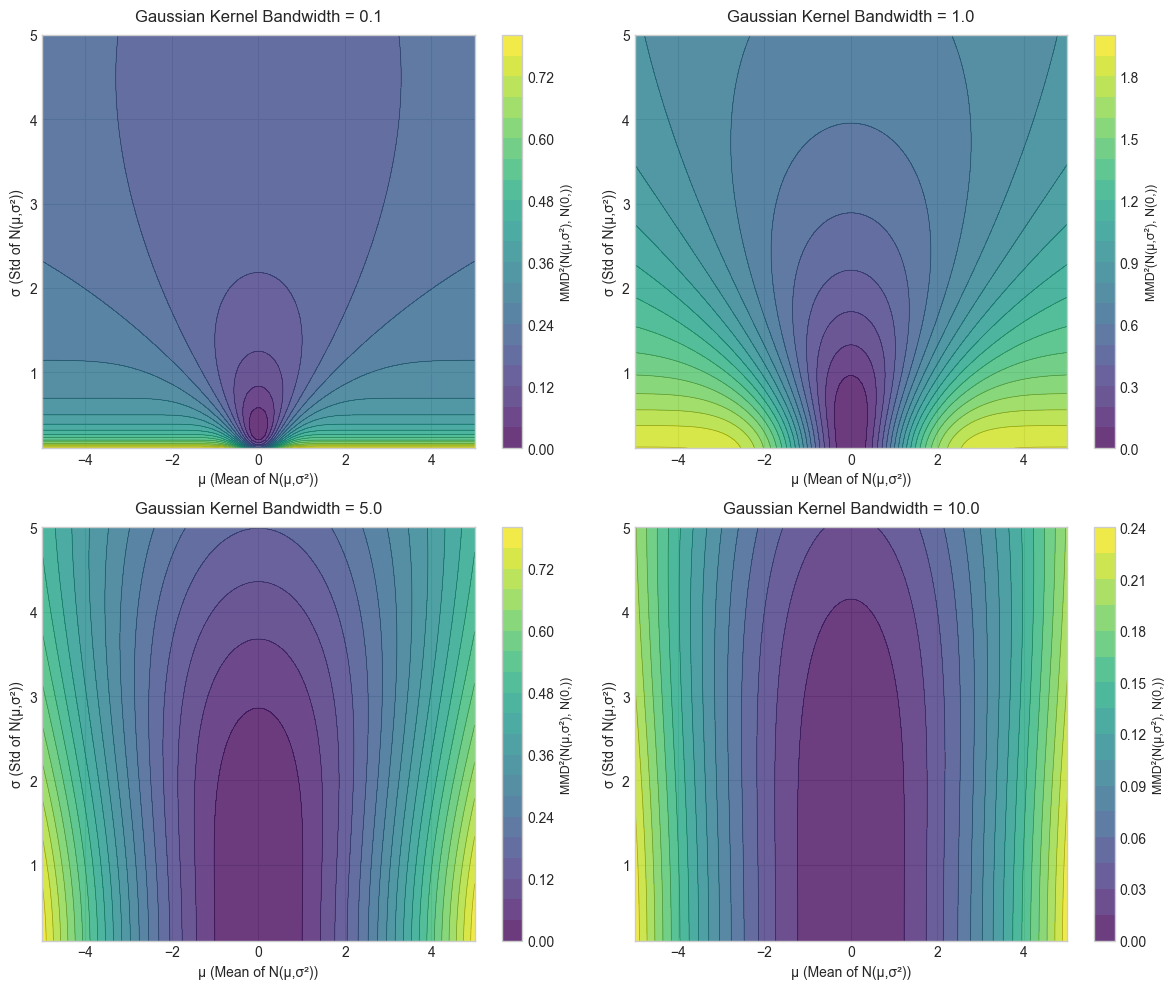

验证：当μ=0, σ=1时，MMD² = 0.11009008（理论值应为0）


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

mean_q = 0.0
var_q = 0.1

def mmd_squared_gaussian(mean_p, var_p, var_q=var_q, mean_q=mean_q, bandwidth=1.0):
    """
    计算两个一维高斯分布之间基于高斯核的MMD平方（解析解）
    分布P: N(mean_p, var_p)，分布Q: N(mean_q, var_q)（默认N(0,1)）
    
    参数:
        mean_p: 分布P的均值 μ
        var_p: 分布P的方差 σ²（注意是方差，不是标准差）
        var_q: 分布Q的方差，默认1.0（对应N(0,1)）
        mean_q: 分布Q的均值，默认0.0（对应N(0,1)）
        bandwidth: 高斯核的带宽（σ_h），控制核的平滑程度
    
    返回:
        mmd_sq: MMD平方值（非负，值越大表示两个分布差异越大）
    """
    # 项1: E_p[k(x,x')] —— 分布P内部样本的核期望
    term1 = 1.0 / np.sqrt(1 + 2 * var_p / (bandwidth **2))
    # 项2: E_q[k(y,y')] —— 分布Q内部样本的核期望
    term2 = 1.0 / np.sqrt(1 + 2 * var_q / (bandwidth** 2))
    # 项3: E_pq[k(x,y)] —— 跨分布样本的核期望
    mean_diff = mean_p - mean_q
    exp_numerator = - (mean_diff **2) / (2 * (var_p + var_q + bandwidth**2))
    cross_denominator = np.sqrt( (var_p + var_q) / (bandwidth**2) + 1 )
    term3 = np.exp(exp_numerator) / cross_denominator
    
    # MMD平方公式：MMD² = term1 + term2 - 2*term3
    mmd_sq = term1 + term2 - 2 * term3
    # 防止数值误差导致的微小负数（MMD²非负）
    mmd_sq = np.maximum(mmd_sq, 0)
    return mmd_sq

# ===================== 1. 设置参数范围 =====================
# μ（均值）范围：[-3, 3]（覆盖N(0,1)的主要概率区间）
mu_min, mu_max = -5, 5
# σ（标准差）范围：[0.1, 3]（避免σ=0，且覆盖N(0,1)的标准差）
sigma_min, sigma_max = 0.1, 5
# 网格点数（越多越精细，100足够平衡精度和速度）
n_grid_points = 100

# 生成μ和σ的网格
mu = np.linspace(mu_min, mu_max, n_grid_points)
sigma = np.linspace(sigma_min, sigma_max, n_grid_points)
mu_grid, sigma_grid = np.meshgrid(mu, sigma)
var_p_grid = sigma_grid **2  # 方差 = 标准差的平方

# ===================== 2. 定义不同的高斯核带宽 =====================
# 选择4个典型带宽（涵盖小/中/大尺度）
bandwidths = [0.1, 1.0, 5.0, 10.0]

# ===================== 3. 计算每个带宽下的MMD² =====================
mmd_results = {}
for bw in bandwidths:
    # 向量化计算整个网格的MMD²（无需循环，效率高）
    mmd_sq_grid = mmd_squared_gaussian(
        mean_p=mu_grid,
        var_p=var_p_grid,
        bandwidth=bw
    )
    mmd_results[bw] = mmd_sq_grid

# ===================== 4. 绘制等高线图 =====================
# 设置绘图样式
plt.style.use('seaborn-v0_8-whitegrid')
fig, axes = plt.subplots(2, 2, figsize=(12, 10))  # 2x2子图展示不同带宽
axes = axes.flatten()  # 展平轴，方便循环

# 遍历每个带宽绘制子图
for idx, bw in enumerate(bandwidths):
    ax = axes[idx]
    mmd_sq_grid = mmd_results[bw]
    
    # 绘制填充等高线（颜色表示MMD²大小）
    contour_filled = ax.contourf(
        mu_grid, sigma_grid, mmd_sq_grid,
        levels=20,  # 等高线层数
        cmap='viridis',  # 颜色映射（蓝=小MMD，黄=大MMD）
        alpha=0.8
    )
    # 叠加轮廓线（增强可读性）
    contour_lines = ax.contour(
        mu_grid, sigma_grid, mmd_sq_grid,
        levels=20,
        colors='black',
        alpha=0.3,
        linewidths=0.5
    )
    
    # 设置子图标题和标签
    ax.set_title(f'Gaussian Kernel Bandwidth = {bw}', fontsize=12, pad=10)
    ax.set_xlabel('μ (Mean of N(μ,σ²))', fontsize=10)
    ax.set_ylabel('σ (Std of N(μ,σ²))', fontsize=10)
    ax.set_xlim(mu_min, mu_max)
    ax.set_ylim(sigma_min, sigma_max)
    
    # 添加颜色条（标注MMD²值）
    cbar = fig.colorbar(contour_filled, ax=ax)
    cbar.set_label('MMD²(N(μ,σ²), N(0,))', fontsize=9)

# 调整子图间距，避免重叠
plt.tight_layout()
# 保存图片（高分辨率）
plt.savefig('mmd_contour_plots.png', dpi=300, bbox_inches='tight')
# 显示图片
plt.show()

# ===================== 验证：当μ=0, σ=1时MMD²≈0 =====================
test_mmd = mmd_squared_gaussian(mean_p=0, var_p=1, bandwidth=1.0)
print(f"验证：当μ={mean_q}, σ={var_q}时，MMD² = {test_mmd:.8f}（理论值应为0）")